2.18.0
Found 768 images belonging to 6 classes.
Found 189 images belonging to 6 classes.
Found 768 images belonging to 6 classes.


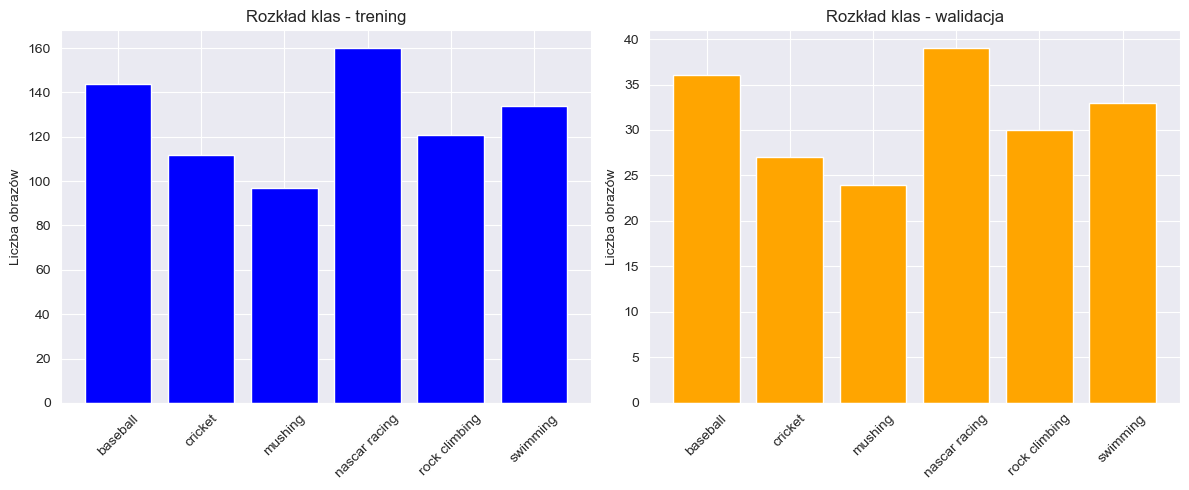

In [9]:
# ====================================
# 1. IMPORTY I USTAWIENIA
# ====================================
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

print(tf.__version__)  # Upewnij się, że TensorFlow działa poprawnie

# Ustawienia
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 6  # 6 sportów
EPOCHS = 10
VALIDATION_SPLIT = 0.2
SEED = 42
DATA_DIR = 'data/train'

# =====================================
# 1. Ustawienie dwóch DataGeneratorów
#    z tym samym validation_split=0.2
#    i tym samym seed=42
# =====================================

# Generator BEZ augmentacji (może służyć do histogramów lub walidacji bez augmentacji)
no_aug_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT  # 80% trening, 20% walidacja
)

# Generator Z augmentacją (używany do treningu)
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)



# =====================================
# 2. Utworzenie train/valid data
# =====================================
train_data = aug_datagen.flow_from_directory(
    directory=DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED,
    subset='training',
)

valid_data = no_aug_datagen.flow_from_directory(
    directory=DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED,
    subset='validation',
)

train_data_eval = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
).flow_from_directory(
    directory=DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED,
    subset='training'
)

# =====================================
# 3. Podgląd histogramu
# =====================================
class_labels = list(train_data.class_indices.keys())

train_labels_no_aug = train_data.classes
valid_labels_no_aug = valid_data.classes

unique_train, counts_train = np.unique(train_labels_no_aug, return_counts=True)
unique_valid, counts_valid = np.unique(valid_labels_no_aug, return_counts=True)

plt.figure(figsize=(12,5))

# Zbiór treningowy - histogram przed augmentacją
plt.subplot(1, 2, 1)
plt.bar([class_labels[i] for i in unique_train], counts_train, color='blue')
plt.title('Rozkład klas - trening')
plt.xticks(rotation=45)
plt.ylabel('Liczba obrazów')

# Zbiór walidacyjny - histogram przed augmentacją
plt.subplot(1, 2, 2)
plt.bar([class_labels[i] for i in unique_valid], counts_valid, color='orange')
plt.title('Rozkład klas - walidacja')
plt.xticks(rotation=45)
plt.ylabel('Liczba obrazów')


plt.tight_layout()
plt.show()# ====================================

In [10]:
from tensorflow.keras.applications import VGG16
# 1. Wczytanie bazy VGG16 (bez głowy)
# ====================================
# include_top=False -> usuwamy wbudowaną klasyfikację VGG16 na 1000 klas
# input_shape=(224,224,3) -> nasz rozmiar wejścia
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Zamrażamy wagi bazy, by nie były modyfikowane podczas trenowania
for layer in base_model.layers:
    layer.trainable = False

# ====================================
# 2. Dodanie własnych warstw (tzw. "głowa" modelu)
# ====================================
model = models.Sequential([
    base_model,               # wstawiamy warstwy VGG16 (zamrożone)
    layers.Flatten(),         # spłaszczenie do wektora
    layers.Dense(256, activation='relu'),  # dodatkowa warstwa gęsta
    layers.Dense(NUM_CLASSES, activation='softmax')  # wyjście na 6 klas
])

model.summary()

# ====================================
# 3. Kompilacja
# ====================================
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# ====================================
# 4. Trening
# ====================================
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=valid_data
)

# ====================================
# 5. Ewaluacja
# ====================================
val_loss, val_accuracy = model.evaluate(valid_data)
print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}")

train_loss, train_accuracy = model.evaluate(train_data_eval)
print(f"Train loss (eval set): {train_loss:.4f}, Train accuracy (eval set): {train_accuracy:.4f}")

# ====================================

# 6. Zapis modelu
# ====================================
model.save("sport_classifier_vgg16.keras")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,139,014 (80.64 MB)

 Trainable params: 6,424,326 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

C:\Users\barte\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.2461 - loss: 6.1339 - val_accuracy: 0.8307 - val_loss: 0.5675
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8247 - loss: 0.5546 - val_accuracy: 0.8836 - val_loss: 0.3764
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8743 - loss: 0.3660 - val_accuracy: 0.8889 - val_loss: 0.3150
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9186 - loss: 0.2361 - val_accuracy: 0.9259 - val_loss: 0.2336
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9485 - loss: 0.1622 - val_accuracy: 0.9153 - val_loss: 0.2422
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9503 - loss: 0.1478 - val_accuracy: 0.9259 - val_loss: 0.2357
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9582 - loss: 0.1242 - val_accuracy: 0.9048 - val_loss: 0.3354
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9426 - loss: 0.1636 - val_accuracy: 0.9153 - val_loss:

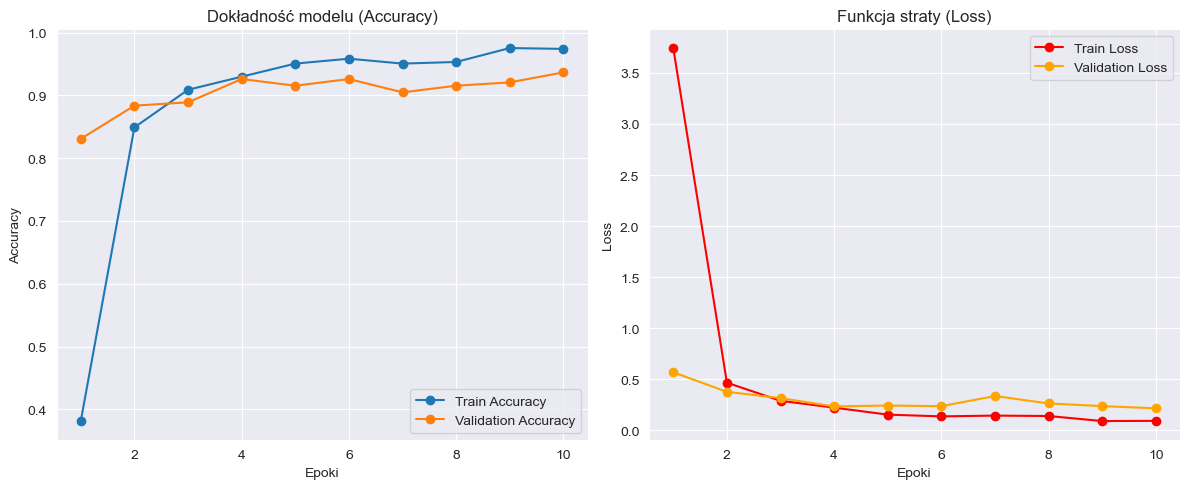

24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step

🏋️‍♂️ Metryki dla zbioru treningowego:
Precision: 0.9925
Recall:    0.9922
F1-score:  0.9922


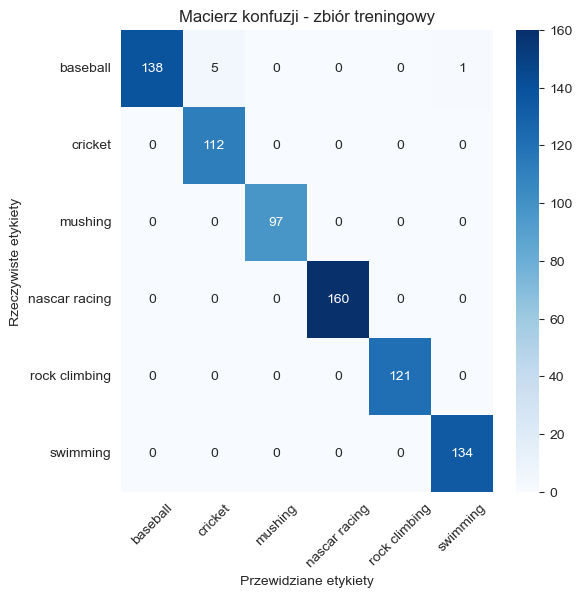


🏋️‍♂️ Raport klasyfikacji - zbiór treningowy:
               precision    recall  f1-score   support

     baseball       1.00      0.96      0.98       144
      cricket       0.96      1.00      0.98       112
      mushing       1.00      1.00      1.00        97
nascar racing       1.00      1.00      1.00       160
rock climbing       1.00      1.00      1.00       121
     swimming       0.99      1.00      1.00       134

     accuracy                           0.99       768
    macro avg       0.99      0.99      0.99       768
 weighted avg       0.99      0.99      0.99       768


🧪 Metryki dla zbioru walidacyjnego:
Precision: 0.9363
Recall:    0.9365
F1-score:  0.9360


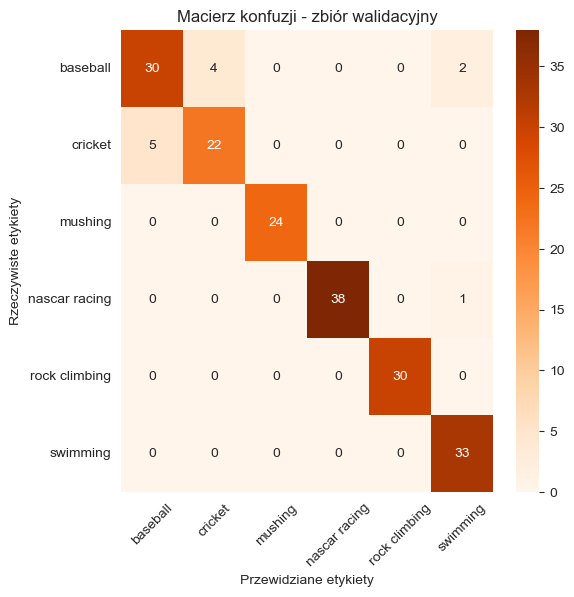


🧪 Raport klasyfikacji - zbiór walidacyjny:
               precision    recall  f1-score   support

     baseball       0.86      0.83      0.85        36
      cricket       0.85      0.81      0.83        27
      mushing       1.00      1.00      1.00        24
nascar racing       1.00      0.97      0.99        39
rock climbing       1.00      1.00      1.00        30
     swimming       0.92      1.00      0.96        33

     accuracy                           0.94       189
    macro avg       0.94      0.94      0.94       189
 weighted avg       0.94      0.94      0.94       189



In [11]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Pobranie metryk z history
import matplotlib.pyplot as plt

# -------------------------------------------------
# 2. Wykresy z history: accuracy i loss
# -------------------------------------------------
train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

epochs_range = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 5))

# Wykres dokładności
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label="Train Accuracy", marker='o')
plt.plot(epochs_range, val_acc, label="Validation Accuracy", marker='o')
plt.title("Dokładność modelu (Accuracy)")
plt.xlabel("Epoki")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Wykres funkcji straty
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label="Train Loss", marker='o', color='red')
plt.plot(epochs_range, val_loss, label="Validation Loss", marker='o', color='orange')
plt.title("Funkcja straty (Loss)")
plt.xlabel("Epoki")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# -------------------------------------------------
# 3. Pobranie etykiet (y_true) i przewidywań (y_pred)
# -------------------------------------------------

# Zbiór treningowy (bez tasowania, bez augmentacji)
y_true_train = train_data_eval.classes
y_pred_train_prob = model.predict(train_data_eval)
y_pred_train = np.argmax(y_pred_train_prob, axis=1)

# Zbiór walidacyjny (zakładamy, że w valid_data jest shuffle=False)
y_true_valid = valid_data.classes
y_pred_valid_prob = model.predict(valid_data)
y_pred_valid = np.argmax(y_pred_valid_prob, axis=1)

# Nazwy klas
class_labels = list(train_data.class_indices.keys())

# -------------------------------------------------
# 4. Metryki dla zbioru treningowego
# -------------------------------------------------
train_precision = precision_score(y_true_train, y_pred_train, average='weighted')
train_recall    = recall_score(y_true_train, y_pred_train, average='weighted')
train_f1        = f1_score(y_true_train, y_pred_train, average='weighted')

print("\n🏋️‍♂️ Metryki dla zbioru treningowego:")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1-score:  {train_f1:.4f}")

# Macierz konfuzji (train)
cm_train = confusion_matrix(y_true_train, y_pred_train)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Macierz konfuzji - zbiór treningowy")
plt.xlabel("Przewidziane etykiety")
plt.ylabel("Rzeczywiste etykiety")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Raport klasyfikacji (train)
report_train = classification_report(y_true_train, y_pred_train, target_names=class_labels)
print("\n🏋️‍♂️ Raport klasyfikacji - zbiór treningowy:")
print(report_train)

# -------------------------------------------------
# 5. Metryki dla zbioru walidacyjnego
# -------------------------------------------------
valid_precision = precision_score(y_true_valid, y_pred_valid, average='weighted')
valid_recall    = recall_score(y_true_valid, y_pred_valid, average='weighted')
valid_f1        = f1_score(y_true_valid, y_pred_valid, average='weighted')

print("\n🧪 Metryki dla zbioru walidacyjnego:")
print(f"Precision: {valid_precision:.4f}")
print(f"Recall:    {valid_recall:.4f}")
print(f"F1-score:  {valid_f1:.4f}")

# Macierz konfuzji (valid)
cm_valid = confusion_matrix(y_true_valid, y_pred_valid)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_valid, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Macierz konfuzji - zbiór walidacyjny")
plt.xlabel("Przewidziane etykiety")
plt.ylabel("Rzeczywiste etykiety")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Raport klasyfikacji (valid)
report_valid = classification_report(y_true_valid, y_pred_valid, target_names=class_labels)
print("\n🧪 Raport klasyfikacji - zbiór walidacyjny:")
print(report_valid)

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Ścieżka do zapisanego modelu
MODEL_PATH = "sport_classifier_vgg16.keras"

# Nazwy klas w takiej kolejności, w jakiej były trenowane w generatorze
class_names = [
    "baseball",
    "cricket",
    "mushing",
    "nascar racing",
    "rock climbing",
    "swimming"
]

# Wczytanie wytrenowanego modelu
model = load_model(MODEL_PATH)

def predict_sport(image_path, model, class_names):
    """
    Funkcja wczytuje pojedynczy obraz, przetwarza go
    i zwraca przewidywaną etykietę (oraz pewność).
    """
    # 1. Wczytanie obrazu i przeskalowanie do rozmiaru 224x224
    img = load_img(image_path, target_size=(224, 224))

    # 2. Konwersja do tablicy NumPy i normalizacja do zakresu [0, 1]
    img_array = img_to_array(img) / 255.0

    # 3. Dodanie wymiaru batch (1, 224, 224, 3), aby sieć mogła przetwarzać dane
    img_array = np.expand_dims(img_array, axis=0)

    # 4. Przewidywanie
    predictions = model.predict(img_array)  # shape: (1, NUM_CLASSES)

    # 5. Indeks klasy z najwyższym prawdopodobieństwem
    predicted_index = np.argmax(predictions[0])
    predicted_label = class_names[predicted_index]

    # Opcjonalnie pewność predykcji (confidence)
    confidence = predictions[0][predicted_index]

    return predicted_label, confidence

# Ścieżka do przykładowego zdjęcia
test_image_path = "image6.jpg"

# Klasyfikacja
label, conf = predict_sport(test_image_path, model, class_names)

print(f"Przewidywany sport: {label}")
print(f"Pewność modelu: {conf * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
Przewidywany sport: baseball
Pewność modelu: 63.56%
